In [1]:
"""
Evaluate a fine-tuned BART model (partial->entire conversation) using BLEU & ROUGE.

Steps:
1) Build partial->entire from CSV
2) Load fine-tuned BART
3) Generate predicted entire conversation from partial
4) Compare with reference entire conversation using BLEU & ROUGE
5) (Optional) visualize BLEU distribution
"""

# Required installations (if needed):
# !pip install nltk evaluate sentencepiece
# import nltk
# nltk.download('punkt')


'\nEvaluate a fine-tuned BART model (partial->entire conversation) using BLEU & ROUGE.\n\nSteps:\n1) Build partial->entire from CSV\n2) Load fine-tuned BART\n3) Generate predicted entire conversation from partial\n4) Compare with reference entire conversation using BLEU & ROUGE\n5) (Optional) visualize BLEU distribution\n'

In [2]:
# =========================================
# 1) Imports
# =========================================
import os
import math
import pandas as pd
import torch

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import evaluate
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration
)

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

c:\Users\DELL\anaconda3\envs\ai-backend\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\DELL\anaconda3\envs\ai-backend\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(



Using device: cpu


In [3]:
# =========================================
# 2) Paths
# =========================================
csv_path = r"C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/testdataset.csv"
model_path = r"C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/bart_partial_entire_model"

partial_ratio = 0.5  # <--- ratio for partial snippet
print("CSV Path:", csv_path)
print("Model Path:", model_path)

CSV Path: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/testdataset.csv
Model Path: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/bart_partial_entire_model


In [4]:
# =========================================
# 3) Build partial->entire from CSV
# =========================================
def build_partial_entire(csv_path, partial_ratio=0.5):
    """
    For each conversation:
      partial snippet = first partial_ratio lines
      entire snippet  = all lines
    Returns list of (partial_str, entire_str)
    """
    df = pd.read_csv(csv_path)
    pairs = []
    for convo_id, group in df.groupby("CONVERSATION_ID"):
        group_sorted = group.sort_values("CONVERSATION_STEP")
        lines = group_sorted["TEXT"].tolist()
        if len(lines) < 2:
            continue

        # entire conversation
        entire_str = "\n".join(lines).strip()

        # partial snippet
        cutoff = max(1, int(len(lines)*partial_ratio))
        partial_lines = lines[:cutoff]
        partial_str = "\n".join(partial_lines).strip()

        if partial_str and entire_str:
            pairs.append((partial_str, entire_str))
    return pairs

pairs = build_partial_entire(csv_path, partial_ratio)
print("Number of partial->entire pairs:", len(pairs))
if pairs:
    print("\nSample pair:\nPartial:", pairs[0][0], "\nEntire:", pairs[0][1])


Number of partial->entire pairs: 29

Sample pair:
Partial: Hello, I need help with my bank account.
Sure, I can help you with that. Can you please provide your account number?
My account number is 12345678.
Thank you. Can you also provide your PIN?
My PIN is 1234.
Thank you. Please hold on while I verify your information.
Okay, I'll wait. 
Entire: Hello, I need help with my bank account.
Sure, I can help you with that. Can you please provide your account number?
My account number is 12345678.
Thank you. Can you also provide your PIN?
My PIN is 1234.
Thank you. Please hold on while I verify your information.
Okay, I'll wait.
Wait, how do I know this is really my bank?
I assure you, this is a legitimate call. You can check the number we are calling from.
Alright, the number does match my bank's number.
Great, now please provide your account number and PIN.
Here is my account number: 12345678 and my PIN: 1234.
Thank you. Your account is now secure.
I'm glad to hear that. Thank you for you

In [7]:
print(pairs[0])

("Hello, I need help with my bank account.\nSure, I can help you with that. Can you please provide your account number?\nMy account number is 12345678.\nThank you. Can you also provide your PIN?\nMy PIN is 1234.\nThank you. Please hold on while I verify your information.\nOkay, I'll wait.", "Hello, I need help with my bank account.\nSure, I can help you with that. Can you please provide your account number?\nMy account number is 12345678.\nThank you. Can you also provide your PIN?\nMy PIN is 1234.\nThank you. Please hold on while I verify your information.\nOkay, I'll wait.\nWait, how do I know this is really my bank?\nI assure you, this is a legitimate call. You can check the number we are calling from.\nAlright, the number does match my bank's number.\nGreat, now please provide your account number and PIN.\nHere is my account number: 12345678 and my PIN: 1234.\nThank you. Your account is now secure.\nI'm glad to hear that. Thank you for your help.\nYou're welcome. Have a nice day.")


In [6]:
# =========================================
# 4) Load Fine-Tuned BART
# =========================================
print("Loading tokenizer and model from:", model_path)
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)
model.to(device)
model.eval()
print("BART model loaded.")


Loading tokenizer and model from: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/bart_partial_entire_model
BART model loaded.


In [8]:
# =========================================
# 5) Generate Entire Conversation from Partial
# =========================================
def generate_entire_conversation(model, tokenizer, partial_text, max_new_tokens=100, num_beams=4):
    """
    Encodes the partial snippet, uses model.generate to produce entire conversation
    (the model was trained so partial->entire).
    """
    inputs = tokenizer(
        partial_text, 
        return_tensors="pt", 
        truncation=True, 
        max_length=256
    ).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            early_stopping=True
        )
    gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return gen_text


In [23]:
partical_convo = pairs[1][0]

In [24]:
full_convo = pairs[1][1]

In [25]:
partical_convo

'Hi, I received a message about a package delivery.\nYes, we have a package for you. Can you confirm your address?'

In [26]:
full_convo

'Hi, I received a message about a package delivery.\nYes, we have a package for you. Can you confirm your address?\nSure, my address is 123 Main St.\nThank you. Your package will be delivered tomorrow.\nGreat, thank you!'

In [27]:
predicted_entire = generate_entire_conversation(model, tokenizer, partical_convo)

In [28]:
predicted_entire

"Hi, I received a message about a package delivery.\nYes, we have a package for you. Can you confirm your address?\nThat would be great. I'll send the message to our official email for confirmation.\nThank you for calling. I will also check with our courier service to verify your identity.\nI understand your concern, but it's our policy not to disclose sensitive information over the phone without proper verification.\nYou're making a mistake. I'm sorry,"

In [30]:
# =========================================
# 6) Evaluate with BLEU & ROUGE
# =========================================
# We'll do sample-level BLEU and store them in a list
# Then we'll do a corpus-level ROUGE with "evaluate" library

rouge_evaluator = evaluate.load("rouge")
smoothing = nltk.translate.bleu_score.SmoothingFunction().method1

bleu_scores = []
predictions = []
references = []

print("Generating & evaluating for each partial->entire pair...")

for i, (partial_str, entire_ref) in enumerate(pairs):
    # 1) Generate entire conversation from partial
    predicted_entire = generate_entire_conversation(model, tokenizer, partial_str)
    
    # store for ROUGE
    predictions.append(predicted_entire)
    references.append(entire_ref)

    # compute sample-level BLEU
    ref_tokens = nltk.word_tokenize(entire_ref.lower())
    hyp_tokens = nltk.word_tokenize(predicted_entire.lower())
    if len(ref_tokens)==0 or len(hyp_tokens)==0:
        bleu = 0.0
    else:
        bleu = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothing)
    bleu_scores.append(bleu)

# now corpus-level ROUGE
rouge_results = rouge_evaluator.compute(predictions=predictions, references=references)
# typical keys: 'rouge1', 'rouge2', 'rougeL', 'rougeLsum'
rouge1 = rouge_results["rouge1"]
rouge2 = rouge_results["rouge2"]
rougeL = rouge_results["rougeL"]

avg_bleu = np.mean(bleu_scores)

print(f"\n=== Results ===")
print(f"Average BLEU on test set = {avg_bleu:.4f}")
print(f"ROUGE-1 F1 = {rouge1:.4f}")
print(f"ROUGE-2 F1 = {rouge2:.4f}")
print(f"ROUGE-L F1 = {rougeL:.4f}")


Generating & evaluating for each partial->entire pair...

=== Results ===
Average BLEU on test set = 0.3716
ROUGE-1 F1 = 0.6323
ROUGE-2 F1 = 0.5913
ROUGE-L F1 = 0.6219


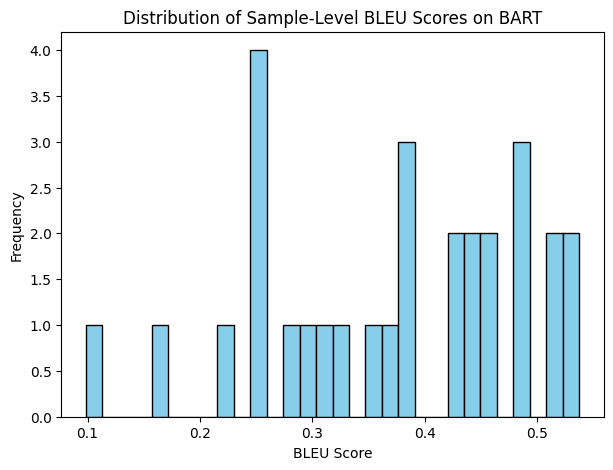

In [31]:
# =========================================
# 7) Visualize BLEU distribution
# =========================================
plt.figure(figsize=(7,5))
plt.hist(bleu_scores, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Sample-Level BLEU Scores on BART")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.show()
